# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))


# 3 features, 2 classes
from cs231n.classifiers.softmax import SoftmaxFun
x_check=np.array([1,2,3])[np.newaxis,:]
class_x_check=0
W_check=np.array([[1,2],[3,4],[5,6]])
def softmax_check(x,class_x,W):
    return np.exp(np.dot(x,W[:,class_x]))/np.sum(np.exp(np.dot(x,W)))
def dsoftmax_check(x,class_x,W):
    S0 = softmax_check(x,0,W)
    S1 = softmax_check(x,1,W)
    dW = np.zeros_like(W)
    if class_x==0:
        dW = np.concatenate((S0*(1-S0)*x.T,S0*(-S1)*x.T),axis=1)
    else:
        dW = np.concatenate((S1*(-S0)*x.T,S1*(1-S1)*x.T),axis=1)
    return dW
softmax = SoftmaxFun()
print("Softmax (closed expression):", softmax_check(x_check,class_x_check,W_check))
print("Softmax (computation graph):", softmax.forward(X=x_check,y=np.reshape(class_x_check,(1,1)),W=W_check))
print("Softmax derivative (closed expression):\n", dsoftmax_check(x_check,class_x_check,W_check))
print("Softmax derivative (computation graph):\n", softmax.backward(1))

loss: 2.366357
sanity check: 2.302585
Softmax (closed expression): [0.00247262]
Softmax (computation graph): [[0.00247262]]
Softmax derivative (closed expression):
 [[ 0.00246651 -0.00246651]
 [ 0.00493302 -0.00493302]
 [ 0.00739953 -0.00739953]]
Softmax derivative (computation graph):
 [[ 0.00246651 -0.00246651]
 [ 0.00493302 -0.00493302]
 [ 0.00739953 -0.00739953]]


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** We have 10 classes. If we initialize all weights with small numbers, the softmax function should take on a value of about 1/10.


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, False)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0, False)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]

grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.744626 analytic: 0.744625, relative error: 1.186027e-07
numerical: 1.605316 analytic: 1.605316, relative error: 1.964894e-09
numerical: -1.628771 analytic: -1.628771, relative error: 1.325298e-08
numerical: -0.589165 analytic: -0.589165, relative error: 3.115843e-08
numerical: -3.728556 analytic: -3.728556, relative error: 2.307240e-08
numerical: 2.583101 analytic: 2.583101, relative error: 2.533390e-08
numerical: -0.342959 analytic: -0.342959, relative error: 1.225614e-07
numerical: 1.674458 analytic: 1.674458, relative error: 1.671614e-08
numerical: 2.644072 analytic: 2.644072, relative error: 1.319162e-08
numerical: -1.600757 analytic: -1.600757, relative error: 4.124456e-08
numerical: -0.155975 analytic: -0.155975, relative error: 2.672473e-07
numerical: 0.523116 analytic: 0.523116, relative error: 8.507474e-09
numerical: 0.177494 analytic: 0.177494, relative error: 5.542543e-08
numerical: 0.933394 analytic: 0.933394, relative error: 4.144658e-08
numerical: -0.014500 a

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.366357e+00 computed in 0.108226s
vectorized loss: 2.366357e+00 computed in 0.006237s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax

results = {}
best_val = -1
best_lr = 0
best_reg = 0
best_softmax = None
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
learning_rates = [10 ** i for i in np.random.uniform(-8,-6,4)]
regularization_strengths = [10 ** i for i in np.random.uniform(3,5,4)]
#lr 7.289744e-07 reg 8.400476e+03 train accuracy: 0.341122 val accuracy: 0.343000

for lr in learning_rates:
    for reg in regularization_strengths:
        sc = Softmax()
        loss_train = sc.train(X=X_train,y=y_train,learning_rate=lr,reg=reg,num_iters=300,batch_size=200)
        predict_train = sc.predict(X=X_train)
        accuracy_train = np.mean(predict_train == y_train)
        predict_val = sc.predict(X=X_val)
        accuracy_val = np.mean(predict_val == y_val)
        results[(lr,reg)]= accuracy_train, accuracy_val
        if best_val < accuracy_val:
            best_val = accuracy_val
            best_reg = reg
            best_lr = lr
            best_softmax = sc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.414260e-08 reg 2.615960e+03 train accuracy: 0.120347 val accuracy: 0.112000
lr 1.414260e-08 reg 6.875755e+03 train accuracy: 0.103061 val accuracy: 0.106000
lr 1.414260e-08 reg 7.740641e+03 train accuracy: 0.132224 val accuracy: 0.124000
lr 1.414260e-08 reg 3.655414e+04 train accuracy: 0.122286 val accuracy: 0.125000
lr 2.708293e-08 reg 2.615960e+03 train accuracy: 0.116653 val accuracy: 0.139000
lr 2.708293e-08 reg 6.875755e+03 train accuracy: 0.114041 val accuracy: 0.117000
lr 2.708293e-08 reg 7.740641e+03 train accuracy: 0.157449 val accuracy: 0.147000
lr 2.708293e-08 reg 3.655414e+04 train accuracy: 0.147898 val accuracy: 0.135000
lr 1.186564e-07 reg 2.615960e+03 train accuracy: 0.185388 val accuracy: 0.173000
lr 1.186564e-07 reg 6.875755e+03 train accuracy: 0.214551 val accuracy: 0.219000
lr 1.186564e-07 reg 7.740641e+03 train accuracy: 0.202653 val accuracy: 0.205000
lr 1.186564e-07 reg 3.655414e+04 train accuracy: 0.300265 val accuracy: 0.317000
lr 1.375040e-07 reg 2.615960

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.319000


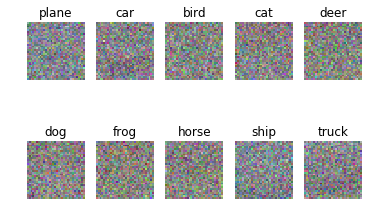

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])